In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error

Matplotlib is building the font cache; this may take a moment.


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
ticker = 'AAPL'
df = yf.download(ticker, '2018-01-01')

/var/folders/lk/1pgk8g3n7sz4srl5kxpbrn080000gn/T/ipykernel_8195/1179894627.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, '2018-01-01')
[*********************100%***********************]  1 of 1 completed


In [14]:
df

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2018-01-02,40.380993,40.390372,39.677736,39.888715,102223600
2018-01-03,40.373966,40.917820,40.310676,40.444293,118071600
2018-01-04,40.561501,40.664645,40.338803,40.446634,89738400
2018-01-05,41.023308,41.110042,40.566192,40.657615,94640000
2018-01-08,40.870941,41.166308,40.772482,40.870941,82271200
...,...,...,...,...,...
2025-08-25,227.160004,229.300003,226.229996,226.479996,30983100
2025-08-26,229.309998,229.490005,224.690002,226.869995,54575100


<Axes: xlabel='Date'>

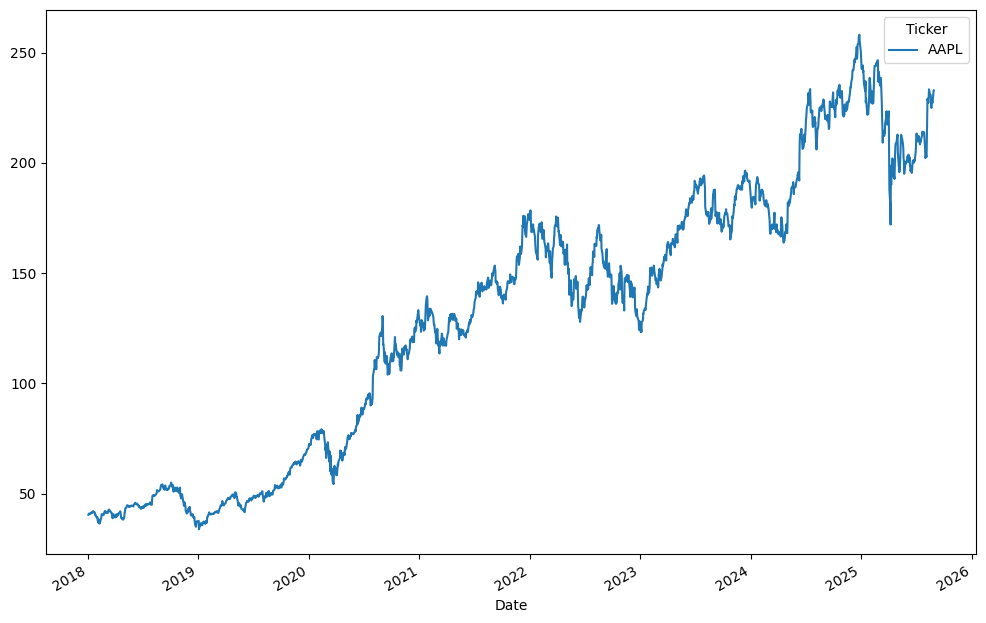

In [15]:
df.Close.plot(figsize=(12, 8))

In [16]:
scaler = StandardScaler()
df['Close'] = scaler.fit_transform(df['Close'])

In [17]:
df.Close

Ticker,AAPL
Date,
2018-01-02,-1.432262
2018-01-03,-1.432374
2018-01-04,-1.429380
2018-01-05,-1.422004
2018-01-08,-1.424438
...,...
2025-08-25,1.550611
2025-08-26,1.584946
2025-08-27,1.603791


In [20]:
seq_length = 30
data = []

for i in range(len(df) - seq_length):
    data.append(df.Close[i:i+seq_length])

data = np.array(data)

In [22]:
data

array([[[-1.43226224],
        [-1.43237446],
        [-1.42937952],
        ...,
        [-1.48921214],
        [-1.46553088],
        [-1.45940369]],

       [[-1.43237446],
        [-1.42937952],
        [-1.42200443],
        ...,
        [-1.46553088],
        [-1.45940369],
        [-1.44801403]],

       [[-1.42937952],
        [-1.42200443],
        [-1.42443774],
        ...,
        [-1.45940369],
        [-1.44801403],
        [-1.42688877]],

       ...,

       [[ 1.27531514],
        [ 1.27308178],
        [ 1.29158591],
        ...,
        [ 1.56019279],
        [ 1.5506109 ],
        [ 1.58494644]],

       [[ 1.27308178],
        [ 1.29158591],
        [ 1.31232341],
        ...,
        [ 1.5506109 ],
        [ 1.58494644],
        [ 1.60379125]],

       [[ 1.29158591],
        [ 1.31232341],
        [ 1.3429513 ],
        ...,
        [ 1.58494644],
        [ 1.60379125],
        [ 1.63684916]]], shape=(1896, 30, 1))

In [39]:
train_size = int(0.8 * len(data))

X_train = torch.from_numpy(data[:train_size, :-1, :]).type(torch.Tensor).to(device)
y_train = torch.from_numpy(data[:train_size, -1, :]).type(torch.Tensor).to(device)
X_test = torch.from_numpy(data[train_size:, :-1, :]).type(torch.Tensor).to(device)
y_test = torch.from_numpy(data[train_size:, -1, :]).type(torch.Tensor).to(device)

In [40]:
class PredictionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(PredictionModel, self).__init__()

        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first = True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device = device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device = device)

        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])

        return out

In [41]:
model = PredictionModel(input_dim = 1, hidden_dim = 32, num_layers = 2, output_dim = 1).to(device)

In [42]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [43]:
num_epochs = 200
for i in range(num_epochs):
    y_train_pred = model(X_train)

    loss = criterion(y_train_pred, y_train)

    if i % 25 == 0:
        print(i, loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

0 0.6852574944496155
25 0.01676378957927227
50 0.0031173371244221926
75 0.0022725278977304697
100 0.0021498759742826223
125 0.002064964734017849
150 0.001989267533645034
175 0.0019205959979444742


In [44]:
model.eval()
y_test_pred = model(X_test)

y_train_pred = scaler.inverse_transform(y_train_pred.detach().cpu().numpy())
y_train = scaler.inverse_transform(y_train.detach().cpu().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().cpu().numpy())
y_test = scaler.inverse_transform(y_test.detach().cpu().numpy())

In [46]:
train_rmse = root_mean_squared_error(y_train[:, 0], y_train_pred[:, 0])
test_rmse = root_mean_squared_error(y_test[:, 0], y_test_pred[:, 0])

In [47]:
train_rmse

2.6999831199645996

In [48]:
test_rmse

8.129414558410645

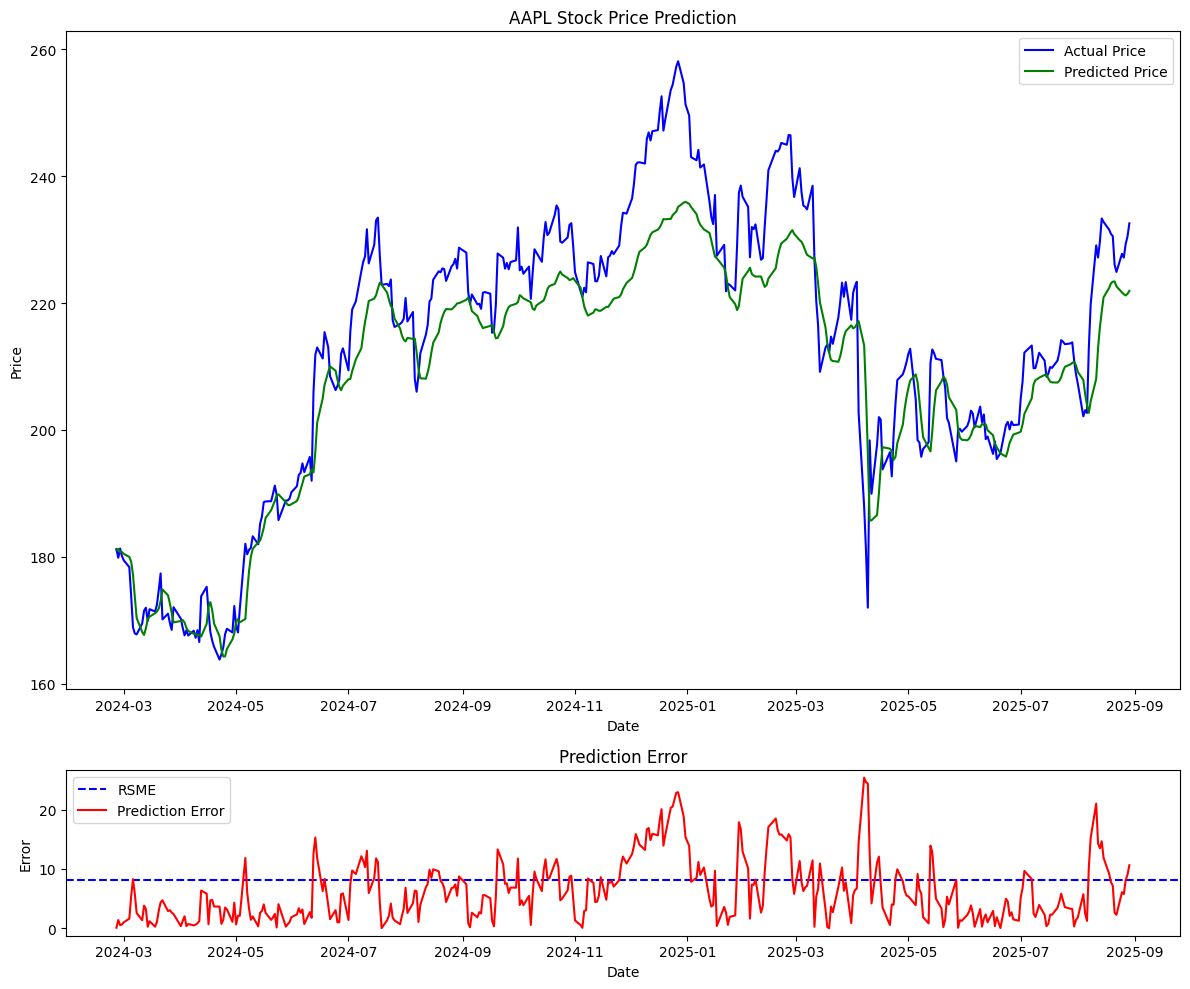

In [53]:
fig = plt.figure(figsize=(12, 10))

gs = fig.add_gridspec(4, 1)

ax1 = fig.add_subplot(gs[:3, 0])
ax1.plot(df.iloc[-len(y_test):].index, y_test, color = 'blue', label = 'Actual Price')
ax1.plot(df.iloc[-len(y_test):].index, y_test_pred, color = 'green', label = 'Predicted Price')
ax1.legend()
plt.title(f"{ticker} Stock Price Prediction")
plt.xlabel('Date')
plt.ylabel('Price')

ax2 = fig.add_subplot(gs[3, 0])
ax2.axhline(test_rmse, color = 'blue', linestyle = '--', label = 'RSME')
ax2.plot(df[-len(y_test):].index, abs(y_test - y_test_pred), 'r', label = 'Prediction Error')
ax2.legend()
plt.title('Prediction Error')
plt.xlabel('Date')
plt.ylabel('Error')
plt.tight_layout()

plt.show()